In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import hydra
import matplotlib.pyplot as plt
import timm
import torch
import torch.nn as nn
import xarray as xr

In [32]:
from crims2s.dataset import S2SDataset, TransformedDataset
from crims2s.training.model.bayes import Projection
from crims2s.util import ECMWF_FORECASTS, collate_with_xarray

In [108]:
with hydra.initialize_config_module('crims2s.training.conf'):
    cfg = hydra.compose('config', overrides=['experiment=conv_fcn'])

***REMOVED***/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [109]:
t = hydra.utils.instantiate(cfg.experiment.transform)
d = TransformedDataset(S2SDataset(cfg.experiment.dataset.dataset_dir), t)

In [110]:
loader = torch.utils.data.DataLoader(d, batch_size=4, collate_fn=collate_with_xarray)

In [111]:
b = next(iter(loader))

In [92]:
pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
pretrained_model.classifier[4] = nn.Conv2d(512, 8, kernel_size=3, stride=1)

Using cache found in ***HOME***.cache/torch/hub/pytorch_vision_v0.10.0


In [105]:
class PretrainedModelWrapper(nn.Module):
    def __init__(self, pretrained_model, in_features):
        super().__init__()
        
        self.projection = Projection(in_features, 3, moments=False, flatten_time=True)
        self.pretrained = pretrained_model
        
    def forward(self, batch):
        x = batch['features_features']
        x = torch.transpose(x, -1, 1)  # Swap channels and time dim.
        
        print('before projection', x.shape)
        
        x = self.projection(x)
        x = x.mean(-1)  # Remove time dimension (which was flattened by the projection).
        
        print('after projection', x.shape)
        
        x = self.pretrained.forward(x)['out']
        
        print('after pretrained', x.shape)
        
        batch_size = x.shape[0]
        
        x_t2m = x[:, :4]
        x_tp = x[:, 4:]
        
        x_t2m = x_t2m.reshape(batch_size, 2, 121, 240, 2)
        x_tp = x_tp.reshape(batch_size, 2, 121, 240, 2)
        
        print('x_t2m', x_t2m.shape)
                
        return x_t2m, x_tp
        

In [106]:
m = PretrainedModelWrapper(pretrained_model, 17)

In [118]:
m = hydra.utils.instantiate(cfg.experiment.model)

Using cache found in ***HOME***.cache/torch/hub/pytorch_vision_v0.10.0


In [120]:
t2m, tp = m(b)

In [121]:
t2m.shape

torch.Size([4, 3, 2, 121, 240])

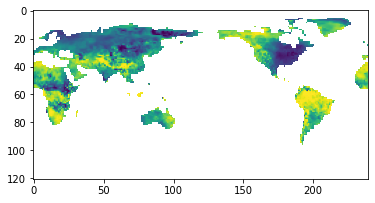

In [125]:
plt.imshow(t2m[0,0,0].detach().numpy())

In [128]:
for k, v in m.named_parameters():
    print(k)

model.conv_model.projection.conv.weight
model.conv_model.projection.bn.weight
model.conv_model.projection.bn.bias
model.conv_model.pretrained.backbone.conv1.weight
model.conv_model.pretrained.backbone.bn1.weight
model.conv_model.pretrained.backbone.bn1.bias
model.conv_model.pretrained.backbone.layer1.0.conv1.weight
model.conv_model.pretrained.backbone.layer1.0.bn1.weight
model.conv_model.pretrained.backbone.layer1.0.bn1.bias
model.conv_model.pretrained.backbone.layer1.0.conv2.weight
model.conv_model.pretrained.backbone.layer1.0.bn2.weight
model.conv_model.pretrained.backbone.layer1.0.bn2.bias
model.conv_model.pretrained.backbone.layer1.0.conv3.weight
model.conv_model.pretrained.backbone.layer1.0.bn3.weight
model.conv_model.pretrained.backbone.layer1.0.bn3.bias
model.conv_model.pretrained.backbone.layer1.0.downsample.0.weight
model.conv_model.pretrained.backbone.layer1.0.downsample.1.weight
model.conv_model.pretrained.backbone.layer1.0.downsample.1.bias
model.conv_model.pretrained.backb